In [1]:
#call free data from nltk
from nltk.corpus import movie_reviews

import pandas as pd
import numpy as np
import scipy
import random
import itertools
import json
import logging

#Text feature Engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.decomposition import TruncatedSVD

#Modelling
#Cross_validation
from sklearn.model_selection import train_test_split
#RandomSearch
from sklearn.model_selection import RandomizedSearchCV
#Modelling Algorithm/classifiers
from sklearn.linear_model import LogisticRegression

#Model Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from tabulate import tabulate
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [2]:
#Call Corpus's Movie_Review Data
reviews = []
for fileid in movie_reviews.fileids():
    tag, filename = fileid.split('/')
    reviews.append((filename, tag, movie_reviews.raw(fileid)))

df = pd.DataFrame(reviews, columns=['filename', 'tag', 'text'])
df.count()
df.head()

,filename,tag,text
0,cv000_29416.txt,neg,"plot : two teen couples go to a church party ,..."
1,cv001_19502.txt,neg,the happy bastard's quick movie review \ndamn ...
2,cv002_17424.txt,neg,it is movies like these that make a jaded movi...
3,cv003_12683.txt,neg,""" quest for camelot "" is warner bros . ' firs..."
4,cv004_12641.txt,neg,synopsis : a mentally unstable man undergoing ...


In [3]:
#Convert Target Variable into Integer.
IsNeg = []
for i in df['tag']:
    if i == 'pos':
        IsNeg.append(0)
    else:
        IsNeg.append(1)     
df['IsNeg'] = IsNeg

Grp2 = df.groupby('IsNeg').size()
print(Grp2)
df.head()

IsNeg
0    1000
1    1000
dtype: int64


,filename,tag,text,IsNeg
0,cv000_29416.txt,neg,"plot : two teen couples go to a church party ,...",1
1,cv001_19502.txt,neg,the happy bastard's quick movie review \ndamn ...,1
2,cv002_17424.txt,neg,it is movies like these that make a jaded movi...,1
3,cv003_12683.txt,neg,""" quest for camelot "" is warner bros . ' firs...",1
4,cv004_12641.txt,neg,synopsis : a mentally unstable man undergoing ...,1


In [5]:
#Random Shuffle Dataset.
from sklearn.utils import shuffle
df = shuffle(df)

print(df['IsNeg'].head())

1821    0
1310    0
1236    0
128     1
96      1
Name: IsNeg, dtype: int64


In [6]:
#split the variables.
X_train=df['text']
Y_train=df['IsNeg']
#define train_test data.
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.5)
X_train.head()

1736    the premise of the new teen-targeted horror fi...
771     plot : lara croft is british , rich and kicks ...
1073    screen story by kevin yagher and andrew kevin ...
1405    plot : good ol' texan kid suddenly gets to pla...
260     i have never been a " star trek " fan , and , ...
Name: text, dtype: object

In [7]:
# feature engineering method: Enhanced Tfidf Vectorizer
tv = TfidfVectorizer(min_df=1,stop_words='english',lowercase=True)
X_traintv = tv.fit_transform(X_train)
X_validationtv = tv.transform(X_validation)

# feature selection by top 10 percentile:
#selector = SelectPercentile(f_classif, percentile = 20)
#selector.fit(X_traintv,Y_train)
#X_traintv = selector.transform(X_traintv)
#X_validationtv = selector.transform(X_validationtv)

In [24]:
X_traintv[0]

<1x29033 sparse matrix of type '<class 'numpy.float64'>'
	with 328 stored elements in Compressed Sparse Row format>

In [17]:
print(X_traintv[0])

  (0, 20311)	0.07347182794239639
  (0, 17868)	0.013701889331122827
  (0, 26389)	0.056768029425275035
  (0, 26281)	0.04255782878594982
  (0, 12715)	0.06908687105178143
  (0, 9934)	0.01621099989164999
  (0, 9957)	0.21383670748266162
  (0, 7128)	0.35398741187457505
  (0, 4270)	0.03127788764066512
  (0, 21411)	0.0486051366581136
  (0, 16702)	0.025260631050044054
  (0, 24005)	0.09310380227988342
  (0, 11884)	0.03471684741172274
  (0, 8950)	0.056768029425275035
  (0, 1948)	0.034067566472624385
  (0, 21823)	0.04495928794265554
  (0, 16112)	0.05149900958614119
  (0, 26898)	0.04655190113994171
  (0, 15801)	0.05149900958614119
  (0, 13065)	0.03933193465273056
  (0, 19177)	0.04495928794265554
  (0, 12598)	0.13097408463574234
  (0, 21311)	0.03193717162109547
  (0, 6133)	0.024409962480670476
  (0, 20074)	0.0486051366581136
  :	:
  (0, 4112)	0.031490953278503486
  (0, 23993)	0.021705702912188242
  (0, 21569)	0.04001217949645606
  (0, 6371)	0.038710919765714634
  (0, 26337)	0.04001217949645606
  (0, 

In [18]:
X_traintv.shape

(1000, 29828)

In [19]:
lsa = TruncatedSVD(n_components=100, n_iter=20)
lsa.fit(X_traintv)
#Lsa is like PCA

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=20,
       random_state=None, tol=0.0)

In [20]:
lsa.components_[0]
#importance of term to the concept, position is the position of the term

array([0.00224094, 0.0116104 , 0.00099273, ..., 0.00047585, 0.00320656,
       0.00060665])

In [24]:
#Convert into readable terms/concepts to see what LSA has done for us.
terms = tv.get_feature_names()
for i, comp in enumerate(lsa.components_):
    termsInComp = zip (terms,comp)
    sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True) [:10]
    print ("Concept %d:" % i)
    for term in sortedTerms:
        print (term[0])
    print (" ")

Concept 0:
film
movie
like
just
good
time
story
characters
really
character
 
Concept 1:
alien
aliens
wars
effects
planet
star
mars
ship
scream
space
 
Concept 2:
scream
horror
julie
movie
killer
summer
slasher
sidney
did
williamson
 
Concept 3:
movie
jackie
chan
action
funny
tucker
godzilla
bad
comedy
snipes
 
Concept 4:
jackie
chan
film
action
damme
vampire
tarantino
vampires
tucker
van
 
Concept 5:
jackie
chan
shrek
film
disney
austin
tarzan
mr
murphy
powers
 
Concept 6:
wars
jackie
scream
movie
chan
phantom
jedi
star
lucas
vampire
 
Concept 7:
wars
star
phantom
film
jedi
10
lucas
jar
menace
spice
 
Concept 8:
vampire
vampires
blade
10
film
disney
tarzan
shrek
snipes
carpenter
 
Concept 9:
austin
powers
evil
54
myers
dr
vampire
vampires
blade
mike
 
Concept 10:
carrey
batman
ace
truman
ventura
austin
wars
powers
jim
vampire
 
Concept 11:
harry
palmetto
shrek
noir
shue
godzilla
harrelson
sevigny
elisabeth
disney
 
Concept 12:
simon
smith
10
vampire
vampires
melvin
blade
wild
joe
west

In [30]:
# Our scoring metric. F1 for useful instances
scoring = make_scorer(f1_score, pos_label=1, average='binary')
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = [1, 2, 4, 8, 16, 32]
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

LogR = LogisticRegression()
#Try random search method.
clf_LogR = RandomizedSearchCV(LogR, hyperparameters, scoring=scoring, random_state=1, n_iter=10, cv=5, verbose=0, n_jobs=-1)

In [31]:
# fit Count Vectorizer's features
clf_LogR.fit(X_traintv,Y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [1, 2, 4, 8, 16, 32], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn',
          scoring=make_scorer(f1_score, pos_label=1, average=binary),
          verbose=0)

In [ ]:
#class for plotting nice confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

          0       0.84      0.80      0.82       512
          1       0.80      0.84      0.82       488

avg / total       0.82      0.82      0.82      1000

Best Penalty: l2
Best C: 2


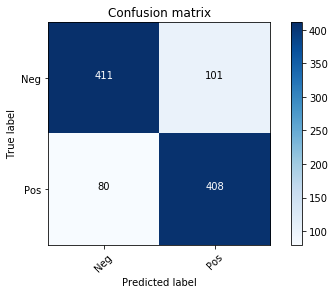

In [33]:
#Run Prediction
y_true, y_pred = Y_validation, clf_LogR.predict(X_validationtv)
#Print Best Model in LogR
print (classification_report(y_true, y_pred))
print('Best Penalty:', clf_LogR.best_estimator_.get_params()['penalty'])
print('Best C:', clf_LogR.best_estimator_.get_params()['C'])
#Print Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['Neg', 'Pos'])
# This explains the really really low recall rate.

In [34]:
logger = logging.getLogger(__name__)

cv_results = clf_LogR.cv_results_
rows = []
for i, params in enumerate(cv_results['params']):
    rows.append((
        json.dumps(params, sort_keys=True),
        '{:.3f} +/- {:.3f}'.format(cv_results['mean_train_score'][i], cv_results['std_train_score'][i]),
        '{:.3f} +/- {:.3f}'.format(cv_results['mean_test_score'][i], cv_results['std_test_score'][i]),
        '{:.3f}'.format(cv_results['mean_fit_time'][i])
        ))
print('Random search results:\n{}'.format(tabulate(rows, headers=['Parameter', 'Train', 'Validation', 'Fit time'], tablefmt='psql')))
print('Best parameter is {} with score of {}.'.format(json.dumps(clf_LogR.best_params_, sort_keys=True), clf_LogR.best_score_))

Random search results:
+----------------------------+-----------------+-----------------+------------+
| Parameter                  | Train           | Validation      |   Fit time |
|----------------------------+-----------------+-----------------+------------|
| {"C": 2, "penalty": "l1"}  | 0.797 +/- 0.005 | 0.701 +/- 0.049 |      0.088 |
| {"C": 2, "penalty": "l2"}  | 0.999 +/- 0.000 | 0.820 +/- 0.029 |      0.076 |
| {"C": 4, "penalty": "l1"}  | 0.940 +/- 0.006 | 0.761 +/- 0.031 |      0.147 |
| {"C": 32, "penalty": "l1"} | 1.000 +/- 0.000 | 0.781 +/- 0.023 |      0.174 |
| {"C": 1, "penalty": "l2"}  | 0.994 +/- 0.001 | 0.809 +/- 0.029 |      0.052 |
| {"C": 8, "penalty": "l1"}  | 0.996 +/- 0.002 | 0.776 +/- 0.027 |      0.159 |
| {"C": 1, "penalty": "l1"}  | 0.665 +/- 0.014 | 0.648 +/- 0.036 |      0.138 |
| {"C": 8, "penalty": "l2"}  | 1.000 +/- 0.000 | 0.815 +/- 0.030 |      0.08  |
| {"C": 32, "penalty": "l2"} | 1.000 +/- 0.000 | 0.814 +/- 0.024 |      0.102 |
| {"C": 16, "pena

C:\Users\Hui Kiang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Hui Kiang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
